# Projet de session

Christophe Manseau

Eugénie Chabenat

Pascal Villeneuve

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
import keras
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F 
from torchvision import datasets, transforms
import time
import sys

## Partie 1

### Importation du jeu de données

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
((X_train, Y_train), (X_test, Y_test)) = fashion_mnist.load_data()


nb_class=len(np.unique(Y_train))

y_one_hot_train=np.zeros((Y_train.shape[0], len(np.unique(Y_train))))
y_one_hot_train[np.arange(Y_train.shape[0]),Y_train]=1

y_one_hot_test=np.zeros((Y_test.shape[0], len(np.unique(Y_test))))
y_one_hot_test[np.arange(Y_test.shape[0]),Y_test]=1

X_train,X_validation,Y_train,Y_validation=train_test_split(X_train,y_one_hot_train,test_size=0.3,random_state=42)

X_train=X_train.reshape((X_train.shape[0],784))
X_test=X_test.reshape((X_test.shape[0],784))
X_validation=X_validation.reshape((X_validation.shape[0],784))


#Mettre le biais
X_train=np.insert(X_train,0,1,axis=1)
X_validation=np.insert(X_validation,0,1,axis=1)
X_test=np.insert(X_test,0,1,axis=1)

### Le perceptron multicouche

In [0]:
import sys 
from IPython.core.debugger import set_trace

EPSILON = 1e-12

def softmax(x):
  return np.exp(x-x.max(1,keepdims=True))/np.exp(x-x.max(1,keepdims=True)).sum(1,keepdims=True)

def get_accuracy(y_pred,y):
  prob=np.argmax(y_pred,axis=1)
  y_prob=np.argmax(y,axis=1)
  accuracy=np.sum(prob == y_prob)/len(y)
  return accuracy
  pass

def get_loss(y,y_pred):
  y_prod=y.dot(-np.log(y_pred.T))
  return (np.diag(y_prod).sum())/y.shape[0]
  pass

def relu(X):
  return np.maximum(0,X)

def d_relu(X):
  if X>0:
    return 1
  else:
    return 0

def Batch_Norm_forward(gamma, beta, x):
  # Mean of the mini-batch
  mu = np.mean(x, axis=0)
  mu=mu.reshape((mu.shape[0],1))
	# Variance of the mini-batch
  var = np.var(x, axis=0)
  std_inv = 1.0 / np.sqrt(var + EPSILON)
  std_inv=std_inv.reshape((std_inv.shape[0],1))
	# The normalized input, x_hat
  # x_hat = (x.T - mu) * std_inv
  x_hat = np.multiply(np.subtract(x.T, mu),std_inv)
	# Batch normalizing (affine) transformation
  # set_trace()
  # y = x_hat.dot(gamma) + beta
  y= np.add(np.multiply(x_hat,gamma),beta)
  backprop_stuff = (gamma, std_inv, x_hat)
  return y.T, mu.reshape((mu.shape[0])), var.reshape((var.shape[0])), backprop_stuff
  # return y.T


def Batch_Norm_forward_test(gamma, beta, x, mu, var):
  std_inv = 1.0 / np.sqrt(var + EPSILON)
  std_inv=std_inv.reshape((std_inv.shape[0],1))
  mu=mu.reshape((mu.shape[0],1))
	# The normalized input, x_hat
  # x_hat = (x - mu) * std_inv
  x_hat = np.multiply(np.subtract(x.T, mu),std_inv)
	# Batch normalizing (affine) transformation
  y= np.add(np.multiply(x_hat,gamma),beta)
  return y.T


def Batch_Norm_backward(dy, backprop_stuff):
  # m: mini-batch size
	# d: number of dimensions
  m, d = dy.shape
  gamma, std_inv, x_hat = backprop_stuff
	# dx_hat = dy * gamma
  dx_hat = np.multiply(dy.T,gamma)
  # Equation 2, 3, 4 in paper
	# Equation 2 was rederived as the one in the paper was not simplified
  dx_hat_mean=np.mean(dx_hat, axis=0)
  dx_hat_mean=dx_hat_mean.reshape((dx_hat_mean.shape[0],1))
  dx_x_hat_mean=np.mean(np.multiply(dx_hat ,x_hat), axis=0)
  dx_x_hat_mean=dx_x_hat_mean.reshape((dx_x_hat_mean.shape[0],1))

  dx = np.multiply(std_inv, np.subtract(np.subtract(dx_hat,dx_hat_mean.T),np.multiply(x_hat, dx_x_hat_mean.T)))
  
  dgamma = np.sum(x_hat.dot(dy), axis=0) #à regarder si la convergence ne se produit pas!!!!!!!
  dgamma=dgamma.reshape((dgamma.shape[0],1))
  dbeta = np.sum(dy, axis=0)
  dbeta=dbeta.reshape((dbeta.shape[0],1))
  # set_trace()
  return dx.T, dgamma, dbeta



v_d_relu=np.vectorize(d_relu)

class MLP(object):

  def __init__(self,Lr,nb_epochs,nb_layer,nb_neurones,minibatch_size):
    self.Lr=Lr
    self.nb_epochs=nb_epochs
    self.nb_layer=nb_layer
    self.nb_neurones=nb_neurones
    self.minibatch_size=minibatch_size
    self.W_input=np.random.normal(0,0.01, (nb_neurones,X_train.shape[1]))
    self.W_hidden=np.random.normal(0,0.01, (nb_layer-1,nb_neurones,nb_neurones))
    self.W_output=np.random.normal(0,0.01, (nb_class,nb_neurones))
    self.Gamma_hidden=np.random.normal(0,0.01, (nb_layer,nb_neurones,1))
    self.Beta_hidden=np.random.normal(0,0.01, (nb_layer,nb_neurones,1))
    self.mu=np.random.normal(0,0.01, (nb_layer,nb_neurones))
    # self.mu=np.reshape((self.mu.shape[0],self.mu.shape[1],1))
    self.var=np.random.normal(0,0.01, (nb_layer,nb_neurones))
    # self.var=np.reshape((self.var.shape[0],self.var.shape[1],1))

    self.losses=[]
    self.losses_valid=[]
    self.accuracies=[]
    self.accuracies_valid=[]
    self.best_accuracy = 0
    self.best_W_input=None
    self.best_W_hidden=None
    self.best_W_output=None
    self.backprop_stuff = None

    self.relu_hidden=np.zeros((nb_layer,int(minibatch_size),nb_neurones))
    self.relu_hidden_valid=np.zeros((nb_layer,X_validation.shape[0],nb_neurones))
    
    self.Y_pred=np.zeros((int(minibatch_size),nb_class))

  

  def feedforward(self,X_train,reLu,W_input,W_hidden,W_output,Gamma,Beta,train,mu,var,backprop_stuff):
    # première couche
    a_0=X_train.dot(W_input.T)
    relu_1=relu(a_0)
    reLu[0]=relu_1
    if self.nb_layer>1:

      # hidden layer
      for i in range(1,nb_layer):
        a=reLu[i-1].dot(W_hidden[i-1].T) #mais w_i-1 c'est juste pour la forme de la matrice
        if train==True:
          a_hat, mu[i-1], var[i-1], self.backprop_stuff=Batch_Norm_forward(Gamma[i-1], Beta[i-1], a)
          # a_hat=Batch_Norm_forward(Gamma[i-1], Beta[i-1], a)
        else:
          a_hat=Batch_Norm_forward_test(Gamma[i-1], Beta[i-1], a, mu[i-1], var[i-1])

        reLu[i]=relu(a_hat)    

    # dernière couche
    a=reLu[nb_layer-1].dot(W_output.T)
    Y_pred=softmax(a)
    return Y_pred, reLu


  def train(self,X_train,Y_train,X_validation,Y_validation):
    for epoch in range(nb_epochs):

      #calcul forward **************************************
      loss=0
      accuracy=0
      accuracies_valid=0
      minibatch_size=self.minibatch_size

      for j in range(0,X_train.shape[0], minibatch_size):
        x_mini=X_train[j:(j+minibatch_size)]
        y_mini=Y_train[j:(j+minibatch_size)]
        train=True
        Y_pred,relu_hidden=self.feedforward(x_mini,self.relu_hidden,self.W_input,self.W_hidden,self.W_output,self.Gamma_hidden,self.Beta_hidden,train,self.mu,self.var,self.backprop_stuff)
 
        loss=(get_loss(y_mini,Y_pred)) #faire attention avec les minibatch
        accuracy=get_accuracy(Y_pred,y_mini)
      



        #Backpropagation **********************************************
        #dernière couche
        de_da_last=-(Y_pred-y_mini)
        grad_last=((de_da_last).T.dot(self.relu_hidden[nb_layer-1]))
        self.W_output=self.W_output+self.Lr*grad_last
        
        # sys.exit()
        
        #Hidden layer
        if self.nb_layer>1:
          for i in range(nb_layer-1,0,-1):
            if i == nb_layer-1:
              # de_da_last=(de_da_last.dot(W_output)).dot(v_d_relu(relu_hidden[i-1]).T.dot(v_d_relu(relu_hidden[i-1])))
              de_da_last=np.multiply(de_da_last.dot(self.W_output),v_d_relu(self.relu_hidden[i])) 
              de_da_last,d_gamma,d_beta=Batch_Norm_backward(de_da_last, self.backprop_stuff)
              grad_last=(de_da_last.T.dot(self.relu_hidden[i-1]))
              self.W_hidden[i-1]=self.W_hidden[i-1]+self.Lr*grad_last
              # set_trace()
              self.Gamma_hidden[i-1] += d_gamma
              self.Beta_hidden[i-1] += d_beta
            else:
              # de_da_last=(de_da_last.dot(W_hidden[i])).dot(v_d_relu(relu_hidden[i-1]).T.dot(v_d_relu(relu_hidden[i-1])))
              de_da_last=np.multiply(de_da_last.dot(self.W_hidden[i]),v_d_relu(self.relu_hidden[i])) 
              de_da_last,d_gamma,d_beta=Batch_Norm_backward(de_da_last, self.backprop_stuff)
              grad_last=((de_da_last).T.dot(self.relu_hidden[i-1]))
              self.W_hidden[i-1]=self.W_hidden[i-1]+self.Lr*grad_last
              self.Gamma_hidden[i-1] += d_gamma
              self.Beta_hidden[i-1] += d_beta
        

        #Premiere couche
        if self.nb_layer>1:
          w2=self.W_hidden[0]
        else:
          w2=self.W_output
        # grad_last=((de_da_last.dot(W_hidden[0])).T.dot(v_d_relu(x_mini))).dot(v_d_relu(x_mini).T.dot(x_mini))
        de_da_last=np.multiply(de_da_last.dot(w2),v_d_relu(self.relu_hidden[0])) 
        grad_last=((de_da_last).T.dot(x_mini))
        self.W_input=self.W_input+self.Lr*grad_last

      train=False
      Y_pred_valid,self.relu_hidden_valid=self.feedforward(X_validation,self.relu_hidden_valid,self.W_input,self.W_hidden,self.W_output,self.Gamma_hidden,self.Beta_hidden,train,self.mu,self.var,self.backprop_stuff)
      loss_valid=(get_loss(Y_validation,Y_pred_valid)) #faire attention avec les minibatch
      accuracy_valid=get_accuracy(Y_pred_valid,Y_validation)

      print("epoch")
      print(epoch)
      print("**********")
      print("accuracy")
      print(accuracy_valid)
      print("**********")
      print("loss")
      print(loss)
      print("**********")

      self.accuracies.append(accuracy)
      self.accuracies_valid.append(accuracy_valid)
      self.losses.append(loss)
      self.losses_valid.append(loss_valid)
      if accuracy > self.best_accuracy:
        self.best_accuracy=accuracy
        self.best_W_input=self.W_input
        self.best_W_hidden=self.W_hidden
        self.best_W_output=self.W_output
        pass


In [0]:
# **********************************
# Création et entrainement du réseau
# **********************************

nb_layer=2
nb_neurones=300
minibatch_size=50
Lr = 0.00000001
nb_epochs=300

start_time = time.time()
MLP_2layer_batch=MLP(Lr,nb_epochs,nb_layer,nb_neurones,minibatch_size)
MLP_2layer_batch.train(X_train,Y_train,X_validation,Y_validation)
end_time= time.time()
duration_time=end_time-start_time

epoch
0
**********
accuracy
0.5323333333333333
**********
loss
4.25915943065171
**********
epoch
1
**********
accuracy
0.6138888888888889
**********
loss
3.434745145618632
**********
epoch
2
**********
accuracy
0.6487777777777778
**********
loss
3.0536083927259496
**********
epoch
3
**********
accuracy
0.6660555555555555
**********
loss
2.6841223050874454
**********
epoch
4
**********
accuracy
0.6776666666666666
**********
loss
2.394669708919467
**********
epoch
5
**********
accuracy
0.6841111111111111
**********
loss
2.203939464801088
**********
epoch
6
**********
accuracy
0.6882222222222222
**********
loss
2.045461946610797
**********
epoch
7
**********
accuracy
0.6917777777777778
**********
loss
1.9731323724880747
**********
epoch
8
**********
accuracy
0.6973333333333334
**********
loss
1.967930405542584
**********
epoch
9
**********
accuracy
0.7038333333333333
**********
loss
1.978958128245846
**********
epoch
10
**********
accuracy
0.7126666666666667
**********
loss
1.877815689361

(0.0, 1.0)

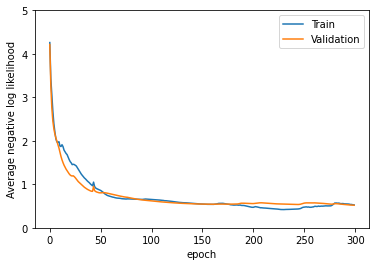

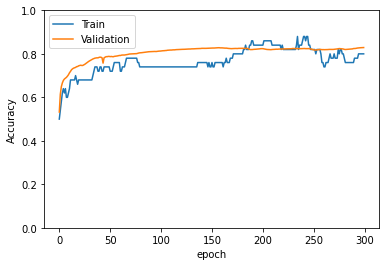

In [0]:
plt.figure(1)
p1=plt.plot(MLP_2layer_batch.losses,label="Train")
p2=plt.plot(MLP_2layer_batch.losses_valid,label="Validation")
plt.xlabel("epoch")
plt.ylabel("Average negative log likelihood")
plt.legend()
plt.ylim(0, 5)


plt.figure(2)
p1=plt.plot(MLP_2layer_batch.accuracies,label="Train")
p2=plt.plot(MLP_2layer_batch.accuracies_valid,label="Validation")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.ylim(0, 1)

In [0]:
(duration_time)

5083.142259597778